In [51]:
import tkinter as tk
import matplotlib.pyplot as plt
from tkinter import filedialog
from pysentimiento import create_analyzer
from pysentimiento.preprocessing import preprocess_tweet
from wordcloud import WordCloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

analyzer = create_analyzer(task="sentiment", lang="es")

In [52]:
def cargar_archivo():
    root = tk.Tk()
    root.withdraw()  # Ocultamos la ventana principal de Tkinter
    file_path = filedialog.askopenfilename()  # Abre el diálogo para seleccionar archivo
    try:
        if file_path:
            print(f"Archivo seleccionado: {file_path}")
            return file_path
    except:
        print("No se seleccionó ningún archivo.")


In [53]:
# Abrimos el archivo de texto
path = cargar_archivo()
with open(path, 'r', encoding='utf-8') as file:
    # Leemos el archivo
    datos = file.read()
resultados_corregidos = {}
exclusiones = [
    "y", "e", "que", "si", "qué", "como",
    "cuando", "mientras", "para", "hasta",
    "este", "esta", "esto", "estos", "estas",
    "el", "la", "los", "las", "un", "una", "unos", "unas", "pero"
]

Archivo seleccionado: C:/Users/DAVID/Documents/Maestria/Aprendizaje Automatico/Practicas de JN para SAA/datasets/ChatNegativo.txt


In [54]:
mensajes_grupo = []
datos = datos.split("\n")
for line in datos:
    parts = line.split(" - ", 1)
    if len(parts) > 1:
        author_message = parts[1]
        if ": " in author_message:
            author, message = author_message.split(": ", 1)
            if message and not message.startswith("\u200e") and "<Multimedia omitido>" not in message:
                sentiment = analyzer.predict(preprocess_tweet(message.lower()))
                if sentiment.probas['NEG'] > 0.45:
                    sentiment = "NEG"
                elif sentiment.probas['POS'] > 0.40:
                    sentiment = "POS"
                else:
                    sentiment = str(sentiment.output)
                if author not in resultados_corregidos:
                    resultados_corregidos[author] = []
                resultados_corregidos[author].append((message, sentiment))
                mensajes_grupo.append((message, sentiment))

resultados_corregidos['GRUPO'] = mensajes_grupo


In [55]:
def limpiar_mensaje(mensaje):
    mensaje = mensaje.lower()
    for signo in [",", ".", ":", ";", "!", "?", "-", "_", "(", ")", "[", "]", "{", "}", "\"", "'", "http", "https", "@", "#"]:
        mensaje = mensaje.replace(signo, " ")
    return mensaje

In [56]:
def contar_palabras_mensajes(mensajes):
    """
    Cuenta las palabras en una lista de mensajes, excluyendo ciertas palabras comunes.
    """
    conteo = {}
    exclusiones = [
        "y", "e", "que", "qué", "como",
        "cuando", "mientras", "para", "hasta",
        "este", "esta", "está", "esto", "estos", "estas",
        "el", "la", "los", "las", "un", "una", "unos", "unas", "pero", "o", "Pero"
    ]
    for mensaje in mensajes:
        palabras = mensaje.split()
        for palabra in palabras:
            if not len(palabra) > 3 or palabra in (['emoji', 'cara'] + exclusiones) or palabra.startswith("@52"):
                if palabra.lower() in ["sí", "si", "no"]:
                    conteo[palabra.lower()] = conteo.get(palabra.lower(), 0) + 1
                continue
            elif palabra not in conteo:
                conteo[palabra.lower()] = 1
            else:
                conteo[palabra.lower()] += 1
    return conteo

In [106]:
def nube_de_palabras(palabras, sentimiento=None, usuario = 'GRUPO'):
    """
    Genera y muestra una nube de palabras directamente en el notebook.
    """
    if not palabras:
        return "No hay palabras para mostrar."

    # Configuración del colormap basada en el sentimiento
    colormap = {
        'Positivo': 'viridis',
        'Negativo': 'Reds',
        'Neutral': 'gray'
    }.get(sentimiento, '')  # Default a cadena vacía si no hay sentimiento o no es reconocido

    # Crear la nube de palabras con el colormap correspondiente
    wordcloud = WordCloud(colormap=colormap, width=800, height=400, background_color='white').generate_from_frequencies(palabras)

    # Configurar y mostrar la figura
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    if sentimiento:
        plt.title(f"Nube de palabras {sentimiento} de {usuario}", pad=20)
    plt.show()  # Mostrar la imagen directamente

In [107]:
#Generar nube de palabras del grupo
palabras_pos_ind = {}
palabras_neg_ind = {}
palabras_neu_ind = {}

for autor in resultados_corregidos.keys():
    mensaje = resultados_corregidos[autor]
    palabras_pos = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "POS"])
    palabras_neg = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "NEG"])
    palabras_neu = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "NEU"])
    palabras_pos_ind[autor] = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "POS"])
    palabras_neg_ind[autor] = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "NEG"])
    palabras_neu_ind[autor] = contar_palabras_mensajes([msg for msg, sent in mensaje if sent == "NEU"])

In [109]:
def nube_de_palabras_usuario(usuario):
    try:
        nube_de_palabras(palabras_pos_ind[usuario], 'Positivo', usuario)
        nube_de_palabras(palabras_neg_ind[usuario], 'Negativo', usuario)
        nube_de_palabras(palabras_neu_ind[usuario], 'Neutral', usuario)
    except KeyError:
        print("Ingresa el nombre correcto del usuario o un usuario existente")
        for usuario in resultados_corregidos.keys():
            print(usuario)

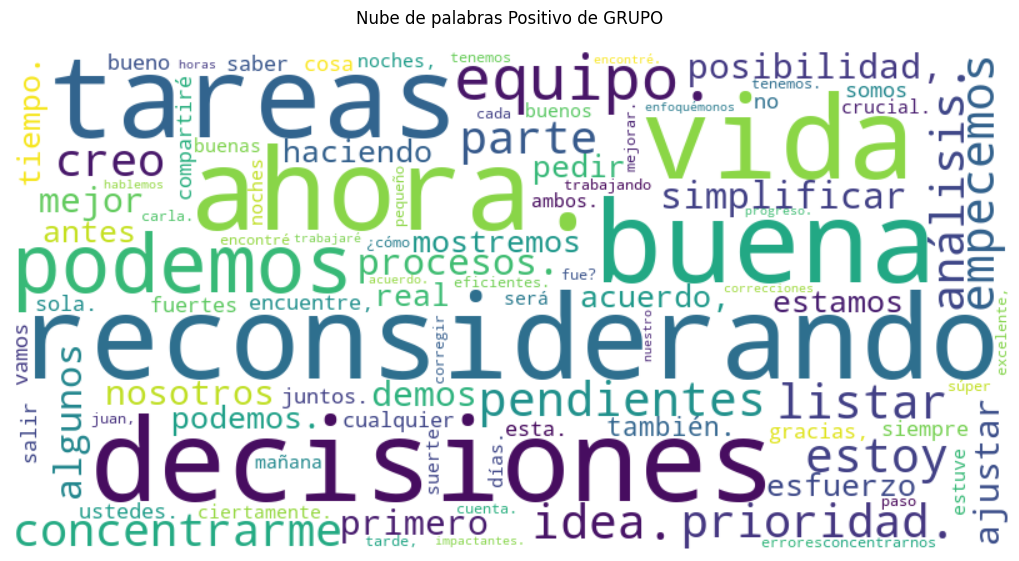

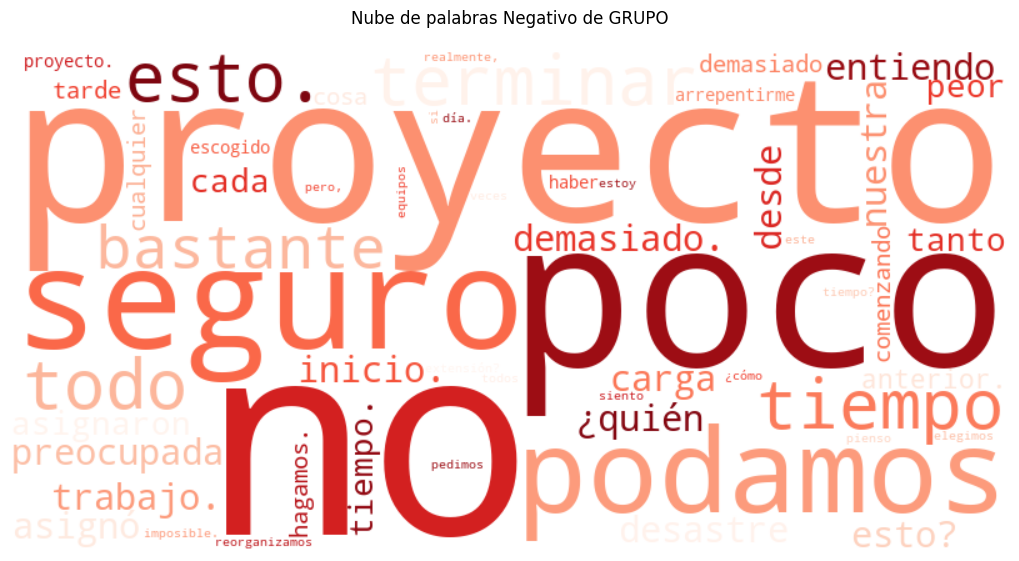

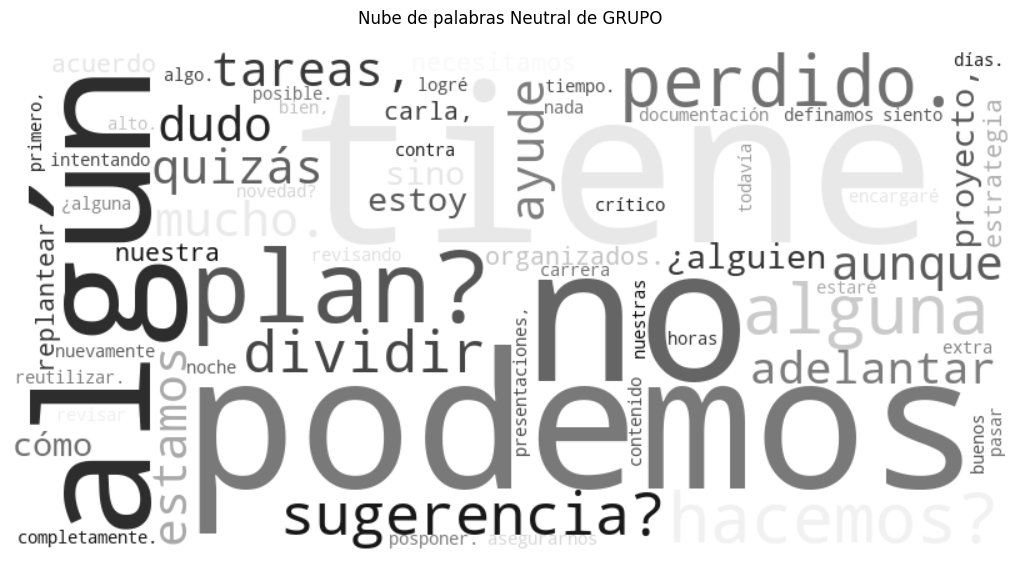

In [111]:
nube_de_palabras_usuario('GRUPO')

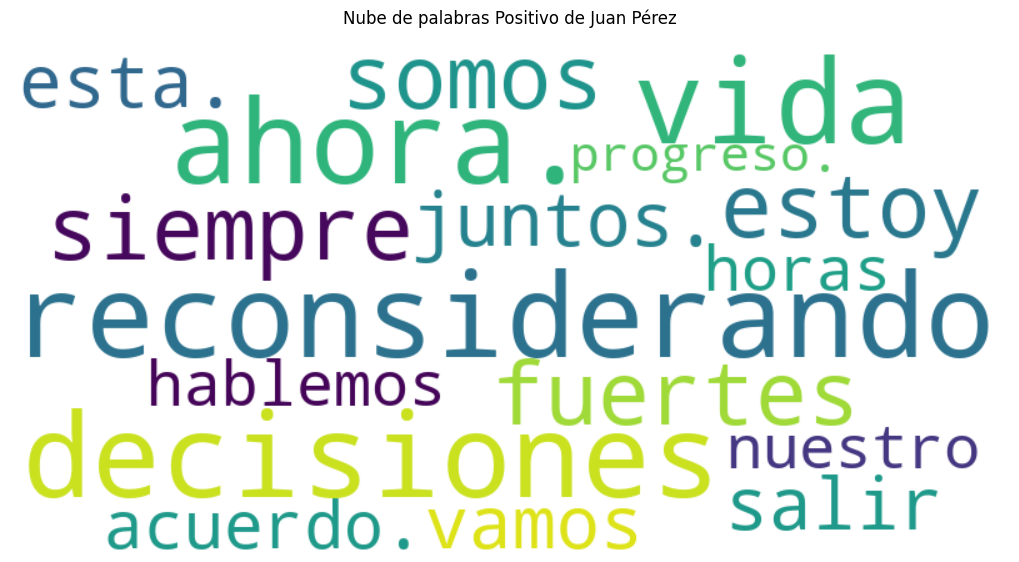

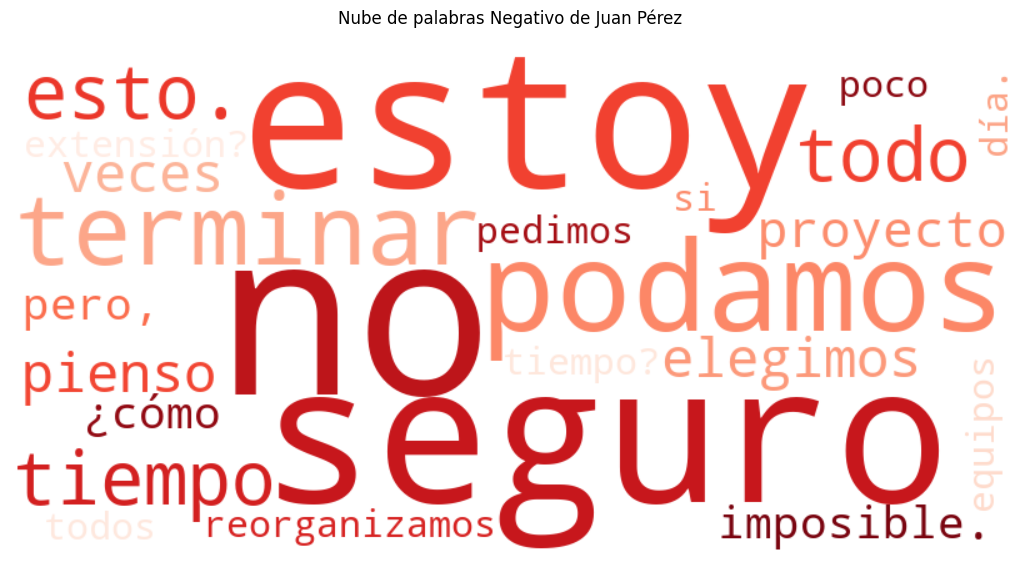

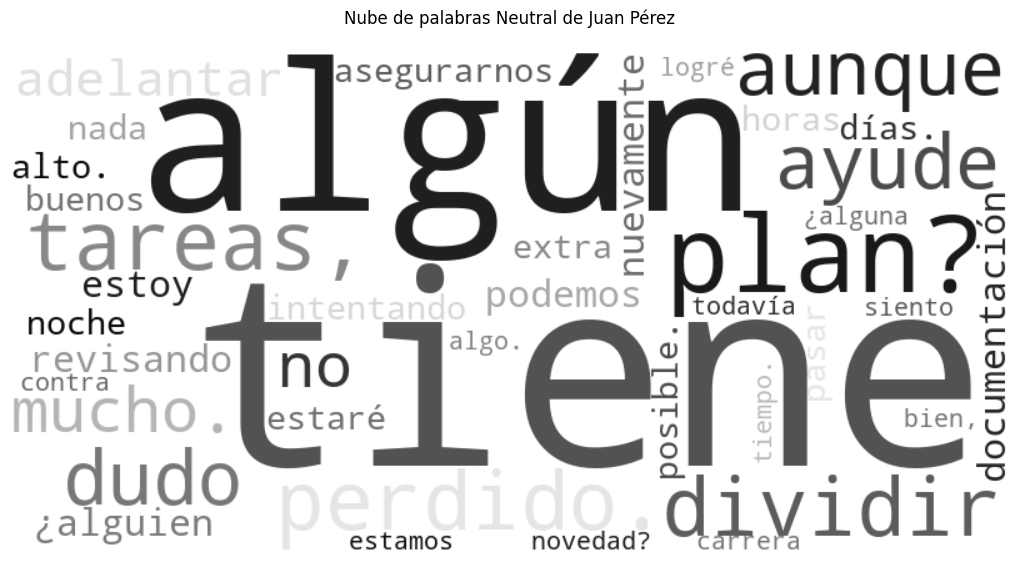

In [110]:
nube_de_palabras_usuario('Juan Pérez')

In [74]:
# Contamos la cantidad de mensajes por usuario y su sentimiento
conteo_mensajes = {}
for usuario in resultados_corregidos.keys():
    conteo_mensajes[usuario] = {
        "POS": 0,
        "NEG": 0,
        "NEU": 0
    }
    for mensaje, sentimiento in resultados_corregidos[usuario]:
        conteo_mensajes[usuario][sentimiento] += 1

In [77]:
conteo_mensajes

{'Juan Pérez': {'POS': 4, 'NEG': 5, 'NEU': 8},
 'Carla Espino': {'POS': 7, 'NEG': 8, 'NEU': 2},
 'María López': {'POS': 6, 'NEG': 6, 'NEU': 4},
 'GRUPO': {'POS': 17, 'NEG': 19, 'NEU': 14}}

In [75]:
# Graficamos la cantidad de mensajes por usuario y sentimiento
def graficar_sentimientos(conteo_mensajes):
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i, sentimiento in enumerate(["POS", "NEG", "NEU"]):
        usuarios = list(conteo_mensajes.keys())
        valores = [conteo_mensajes[usuario][sentimiento] for usuario in usuarios]
        ax[i].barh(usuarios, valores, color="skyblue")
        ax[i].set_title(sentimiento)
    plt.show()

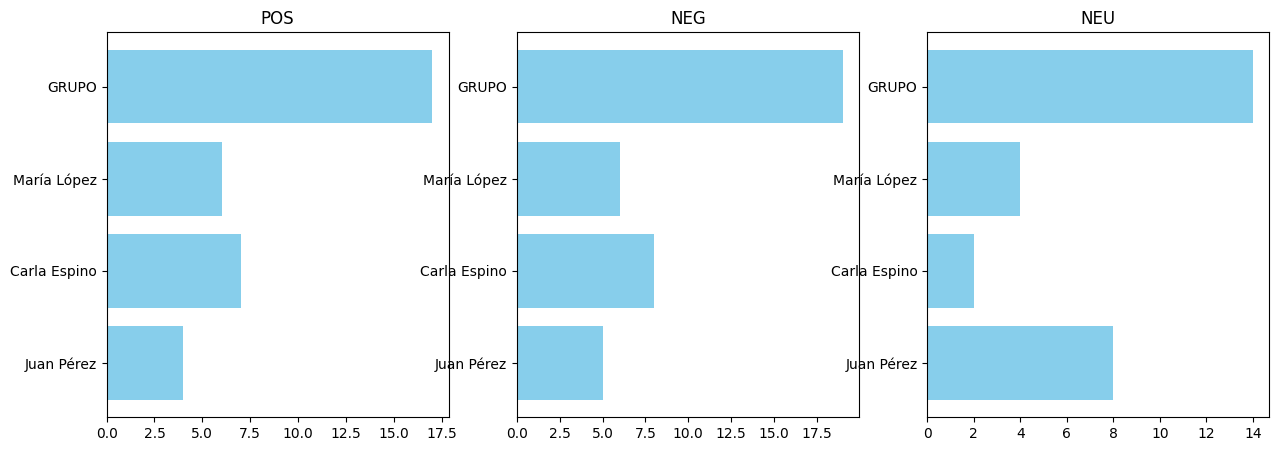

In [76]:
graficar_sentimientos(conteo_mensajes)

In [102]:
def barras(usuario):
    sentimientos = conteo_mensajes[usuario]

    # Nombres de las categorías
    categorias = list(sentimientos.keys())
    # Valores correspondientes
    valores = list(sentimientos.values())

    # Creando el gráfico de barras
    plt.figure(figsize=(8, 5))  # Tamaño del gráfico
    plt.bar(categorias, valores, color=['green', 'red', 'gray'])  # Colores para cada tipo de sentimiento

    # Añadiendo título y etiquetas
    plt.title(f'Distribución de Sentimientos en Mensajes del {usuario}')
    plt.xlabel('Sentimiento')
    plt.ylabel('Cantidad de Mensajes')

    # Mostrando el gráfico
    plt.show()

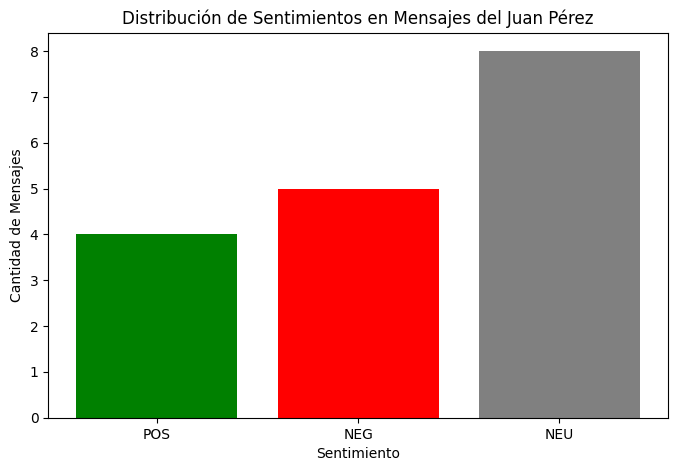

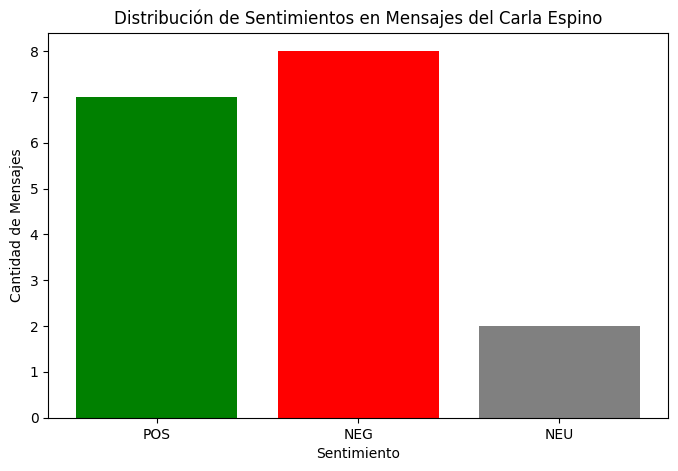

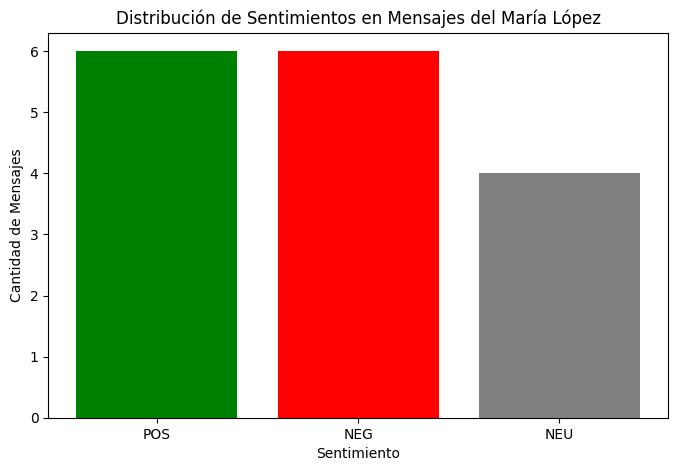

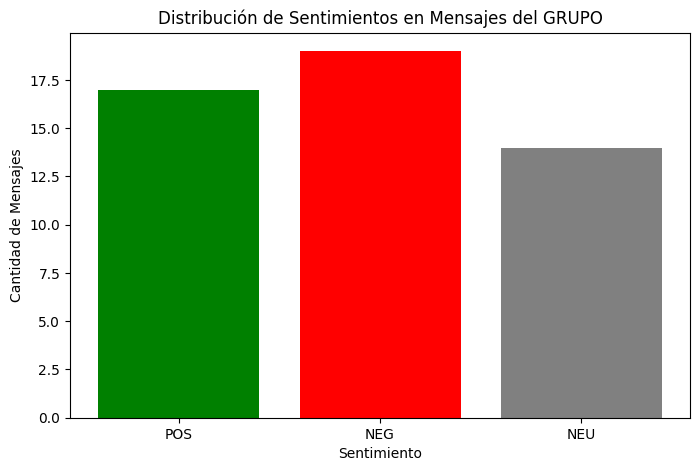

In [103]:
for usuario in resultados_corregidos.keys():
    barras(usuario)